In [20]:
import pandas as pd
import glob
from numpy.ma import sort


#Cargo todos las transaciones
path =r'C:/Desarrollo/data sets/'
allFiles = glob.glob(path + "/*.csv")
tf = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

In [21]:
#Preprocesamiento de la data
#Este dataframe contiene todas las transacciones
tf = pd.concat(list_, sort=False)

In [22]:
#Este dataframe contiene listas  blancas y negras
lf= pd.read_csv('C:/Desarrollo/data sets/list/lists201610201705.csv')

In [23]:
#Filtrado de la data
#Filtro estados 11 y 12 chargeback=true
froudT= tf [(tf.status==11) | (tf.status==12)|(tf.chargeback==True) ]

#Filtrado  lista negra
froudL= lf[(lf.blacklist==True)]

#Join of  Dataframes froudulentos es outer por que puede cumplir cualquera de las condiciones
froudj= froudT.merge(froudL, left_on='uuid',right_on='uuid', how='outer')
froudj=froudj.drop(["eval_uuid","blacklist","whitelist"], axis=1)
print('Total de transacciones fraudulentas')
print(froudj.count())


Total de transacciones fraudulentas
uuid             28400
creation_date    21949
email            21949
card             21949
status           21949
chargeback       21949
amount           21949
dtype: int64


In [24]:
#Expansion de fraude: join por email y por tarjeta de transaciones fraudulentas
froudTotal=froudj.merge(tf,left_on=['email','card'],right_on=['email','card'], how='inner')
froudTotal=froudTotal.drop(["status_x","uuid_x", "creation_date_x", "chargeback_x", "amount_x" ],axis=1)
froudTotal.set_index('uuid_y')
froudTotal.rename( columns={"uuid_y":"uuid","creation_date_y":"creation_date","status_y":"status",
                                           "chargeback_y":"chargeback","amount_y":"amount"},inplace=True)
#elimino valores duplicados
froudTotal=froudTotal.drop_duplicates(keep='first')

print(' Expansion de fraude ')
print(froudTotal.count())

 Expansion de fraude 
email            46325
card             46325
uuid             46325
creation_date    46325
status           46325
chargeback       46325
amount           46325
dtype: int64


In [25]:
#Transacciones legitimas
lt2=tf [(tf.status==8)]
# encuentro  valores comunes entre legitimas y  fraudulentas
trueNegatives=lt2.merge(froudTotal, left_on=['uuid','email','card','creation_date','status', 'chargeback','amount'], right_on=['uuid','email','card','creation_date','status', 'chargeback','amount'], how='inner')

frames=[lt2,trueNegatives]
#borro duplicados para dejar solo las legitimas que cumplen con regla 1 y 2
legitimTotal=pd.concat(frames)
legitimTotal=legitimTotal.drop_duplicates(keep=False)
print(' Total legitimas ')
print(legitimTotal.count())

 Total legitimas 
uuid             453018
creation_date    453018
email            453018
card             453018
status           453018
chargeback       453018
amount           453018
dtype: int64


In [26]:
#agrego flag de clasificacion despues  de ejecutar las reglas
froudTotal['isFraud']= True
legitimTotal['isFraud']= False

#unifico y obtengo mi nuevo dataset
frames=[froudTotal,legitimTotal]
newDataSet=pd.concat(frames, sort=True)
newDataSet.set_index('uuid')


#agrego longitud de correo  y  el dominio
newDataSet['LengthEmail']= newDataSet['email'].map(str).apply(len)
def domainsplit(x):
    try:
        return x.split('@')[1]
    except:
        return 'not domain'
newDataSet['domain']= newDataSet['email'].apply(lambda x:domainsplit(x))

# # agrego contador de email

newDataSet['countEmail']= newDataSet.groupby('email').cumcount() + 1

print(newDataSet.count())

amount           499343
card             499343
chargeback       499343
creation_date    499343
email            499343
isFraud          499343
status           499343
uuid             499343
LengthEmail      499343
domain           499343
countEmail       499343
dtype: int64


In [27]:
newDataSet.head()


,amount,card,chargeback,creation_date,email,isFraud,status,uuid,LengthEmail,domain,countEmail
0,10.0,52EA828244A19F016AFF0BE6BE7E2FA0DED0BCEB3971CE...,False,2016-10-01T00:12:32Z,em19i_k9_@hotmail.com,True,8,-5631698267031680927,21,hotmail.com,1
1,55.0,52EA828244A19F016AFF0BE6BE7E2FA0DED0BCEB3971CE...,True,2016-10-01T00:31:36Z,em19i_k9_@hotmail.com,True,11,-6604111154923827804,21,hotmail.com,2
2,10.0,52EA828244A19F016AFF0BE6BE7E2FA0DED0BCEB3971CE...,False,2016-10-02T05:14:57Z,em19i_k9_@hotmail.com,True,8,-4756153771826776663,21,hotmail.com,3
3,91.0,52EA828244A19F016AFF0BE6BE7E2FA0DED0BCEB3971CE...,True,2016-10-02T05:42:37Z,em19i_k9_@hotmail.com,True,11,-5953423335869321638,21,hotmail.com,4
4,10.0,52EA828244A19F016AFF0BE6BE7E2FA0DED0BCEB3971CE...,False,2016-10-02T16:31:15Z,em19i_k9_@hotmail.com,True,8,-7771278947251870624,21,hotmail.com,5


In [28]:
#Describe entre fraudulentos  yno frudulentos
print (froudTotal.describe())
print (legitimTotal.describe())


               uuid        status        amount
count  4.632500e+04  46325.000000  46325.000000
mean  -6.916078e+18      9.339946     46.277557
std    1.331781e+18      2.331973     71.375483
min   -9.223239e+18      3.000000      6.000000
25%   -8.072075e+18      8.000000     10.000000
50%   -6.912308e+18      8.000000     10.000000
75%   -5.759719e+18     12.000000     62.000000
max   -4.611710e+18     12.000000   1563.000000
               uuid    status         amount
count  4.530180e+05  453018.0  453018.000000
mean  -6.917892e+18       8.0      34.099748
std    1.331460e+18       0.0      43.977120
min   -9.223365e+18       8.0       5.000000
25%   -8.071205e+18       8.0      10.000000
50%   -6.915065e+18       8.0      10.000000
75%   -5.765594e+18       8.0      48.000000
max   -4.611688e+18       8.0     942.000000


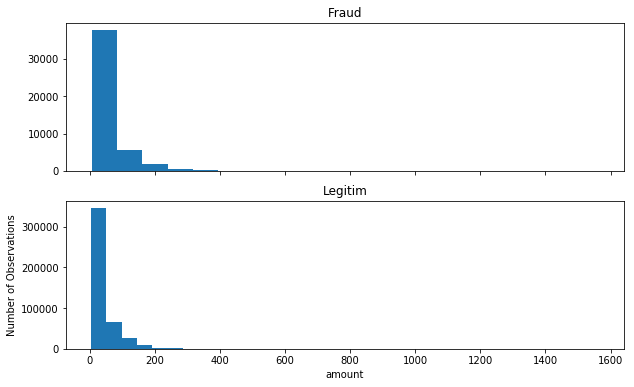

In [29]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

bins = 20

ax1.hist(froudTotal.amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(legitimTotal.amount, bins = bins)
ax2.set_title('Legitim')

plt.xlabel('amount')
plt.ylabel('Number of Observations')
plt.show()



In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
newDataSet=newDataSet.drop(["card","creation_date","email", "domain"], axis=1)
scaler.fit(newDataSet)
train_feature_trans = scaler.transform(newDataSet)
test_feature_trans = scaler.transform(newDataSet)

ModuleNotFoundError: No module named 'sklearn'

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


Using TensorFlow backend.
